# ★Chapter8：資訊圖表的視覺化手法

## 何謂資訊圖表

## 象形圖

## 排列圖片的方法

## 資訊圖表使用的函式庫

程式8.1　載入pillow

In [1]:
from PIL import Image, ImageOps
from IPython.display import display

## 利用圖片大小強調數量多寡

程式8.2　載入圖片與顯示圖片的範例

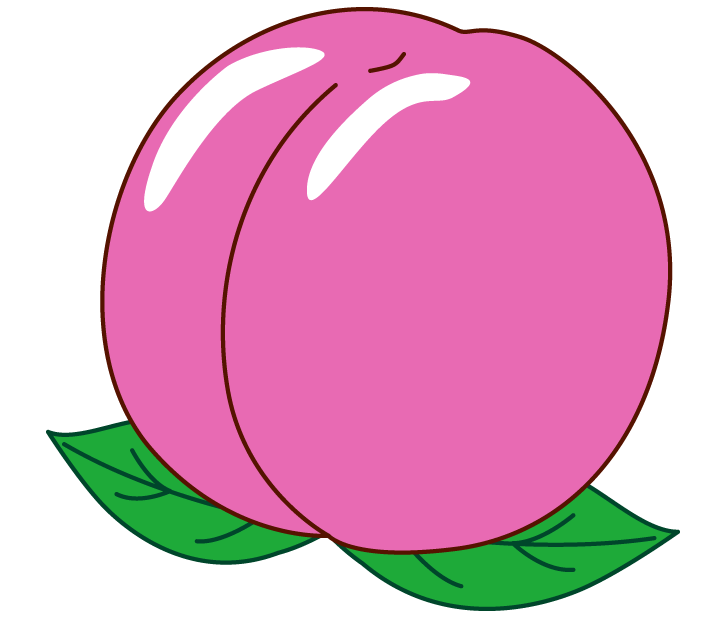

In [2]:
im = Image.open("fruit_momo.png")
display(im)

程式8.3　調整圖片大小的範例

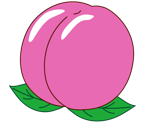

(145, 123)


In [3]:
mini_im = im.resize((int(im.size[0] * 0.2), int(im.size[1] * 0.2)))
display(mini_im)
print(mini_im.size)

## 利用圖片的個數強調數量

程式8.4　以人形圖示的個數強調數量的範例

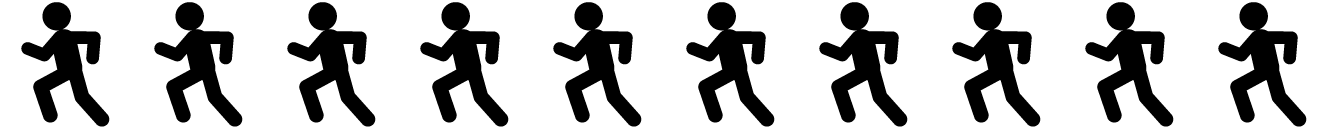

In [4]:
# 要排列的圖示個數
num = 10

# 圖片之間的邊界
margin = 5

# 載入圖片
im = Image.open("human.png")
im_width, im_height = im.size

# 將圖片入作為畫布使用的Image
canvas = Image.new("RGBA", ((im_width + margin) * num, im_height))
for i in range(num):
    canvas.paste(im, ((im_width + margin) * i, 0))

canvas

程式8.5　圖片較多時，在適當的位置換行的範例

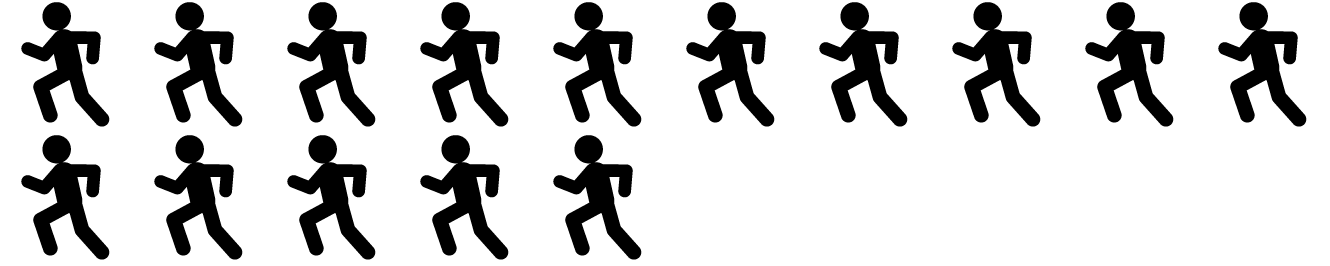

In [5]:
import math

# 圖片並列個數
num = 15

# 換行位置
wrap_num = 10

# 圖片之間的邊界
margin_h = 5
margin_v = 5

# 載入圖片
im = Image.open("human.png")
im_width, im_height = im.size

# 將圖片入作為畫布使用的Image
canvas = Image.new("RGBA", ((im_width + margin_h) * wrap_num, 
                            (im_height + margin_v) * math.ceil(num / wrap_num)))
for i in range(num):
    x = (im_width + margin_h) * (i % wrap_num)
    y = (im_height + margin_v) * (i // wrap_num)
    canvas.paste(im, (x, y))

canvas

## 利用圖片強調比例

程式8.6　載入圖片

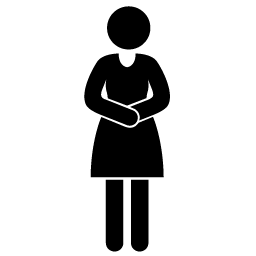

In [6]:
from PIL import Image, ImageOps
from IPython.display import display

im = Image.open("original_icon\woman.png")
display(im)

程式8.7　利用單一圖片的顏色強調比例的範例

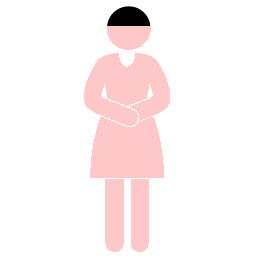

In [7]:
def fill(image, percentage=100):
    start = int(image.size[1] / 100 * percentage)
    for y in range(image.size[1] - start, image.size[1]):
        for x in range(image.size[0]):
            if image.getpixel((x, y))[3] != 0:
                image.putpixel((x, y), (255, 200, 200))
                
fill(im, 90)
display(im)

程式8.8　利用多張圖片的顏色差異強調比例的範例

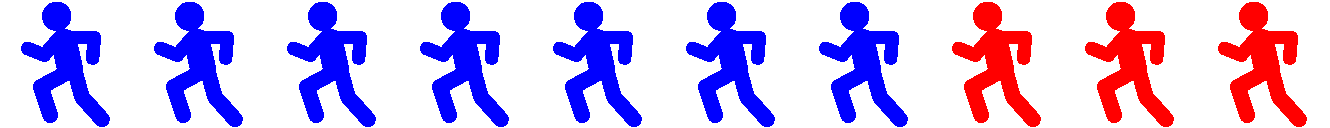

In [8]:
# 圖片並列個數
num = 10

# 圖片之間的邊界
margin = 5

# 以指定的顏色替圖片填色的函數
def fill(image, color=(255, 255, 255)):
    for y in range(image.size[1]):
        for x in range(image.size[0]):
            if image.getpixel((x, y))[3] != 0:
                image.putpixel((x, y), color)
                
# 載入圖片
im = Image.open("human.png")
im_width, im_height = im.size

# 將圖片入作為畫布使用的Image
canvas = Image.new("RGBA", ((im_width + margin) * num, im_height))
for i in range(num):
    if i < 7:
        # 到第7張圖片之前的圖片都是藍色
        color = (0, 0, 255)
    else:
        # 第7張圖片之後的圖片都是紅色
        color = (255, 0, 0)
        
 # 以指定的顏色替圖片填色
    color_im = im.copy()
    fill(color_im, color)
    
    # 貼入圖片
    canvas.paste(color_im, ((im_width + margin) * i, 0))
    
canvas

## 將圖片排列成長條圖的格式

程式8.9　定義繪製圖表的類別

In [9]:
from PIL import Image, ImageDraw, ImageFont

class IconGraph:
    # 初始化的內容
    def __init__(self, data, icon_size=(128, 128), size=(800, 800),
                 back_color=(255, 255, 255), 
                 label_back_color=(255, 255, 255),
                 font="C:\Windows\Fonts\msjh.ttc", 
                 font_size=24, font_color=(0, 0, 0)):
        
        self.canvas_size = [size[0], size[1]]  # 圖表的整體大小
        self.label_field_height = 100  # 繪製標籤區塊的高度
        # 繪製圖表的範圍大小
        self.graph_size = [self.canvas_size[0], 
                           self.canvas_size[1] - self.label_field_height]
        self.icon_size = icon_size  # 圖示的大小
        self.back_color = back_color # 圖表區塊的背景色
        self.label_back_color = label_back_color  # 標籤區塊的背景色
            
        # 設定標籤資訊
        self.labels = []
        for d in data:
            self.labels.append(d["label"])
              
        # 取得value的最大值
        value_max = data[0]["value"]
        for d in data:
            if value_max < d["value"]:
                value_max = d["value"]
        
        # 儲存格的個數
        self.grid_y = value_max  # 儲存格的個數（垂直）
        self.grid_x = len(data)  # 儲存格的個數（水平）
        
        # 儲存格的大小
        # 單一儲存格可使用的高度
        self.grid_height = self.icon_size[1]  
        # 單一儲存格可使用的寬度
        self.grid_width = self.graph_size[0] // self.grid_x
        
        # 距離儲存格中心點的位移量
        self.grid_med_offset = (self.grid_width // 2, self.grid_height // 2)  
        
        # 假設圖表區塊的高度不夠就自動擴張
        if self.graph_size[1] < self.grid_height * self.grid_y:
            self.graph_size[1] = self.grid_height * self.grid_y
            self.canvas_size[1] = self.grid_height * self.grid_y \
                                  + self.label_field_height
        
        # 建立格點
        self.grid = [[None for i in range(self.grid_y)] \
                     for j in range(self.grid_x)]
        
        # 於格點新增圖片
        for x in range(len(data)):
            target = data[x]
            icon = Image.open(target["image"])
            for j in range(target["value"]):
                self.grid[x][j] = icon
        
        # 設定標籤的字型
        self.font = ImageFont.truetype(font, font_size)
        self.font_color = font_color
        
        # 繪製圖表
        self._draw()

        
    # 繪製圖表
    def _draw(self):
        # 建立繪製畫布與圖表的區塊
        self.canvas = Image.new("RGBA", self.canvas_size, self.label_back_color)
        self.graph_field = Image.new("RGBA", self.graph_size, self.back_color)
        
        # 在圖表區塊繪製圖示
        for x in range(len(self.grid)):
            # 計算繪製位置
            x_offset = x * self.grid_width  # 儲存格左端的座標
            
            # 繪製標籤
            imd = ImageDraw.Draw(self.canvas)
            # 計算標籤的大小
            label_size = imd.textsize(self.labels[x], self.font)  
            # 標籤左端的座標
            label_x = x_offset + self.grid_med_offset[0] - label_size[0] // 2  
            
            imd.text((label_x, self.graph_size[1]), self.labels[x], 
                     font=self.font, fill=self.font_color)
            
            # 繪製圖示
            for y in range(len(self.grid[x])):
                if self.grid[x][y] is None:
                    continue
                c_x = x_offset + self.grid_med_offset[0] \
                      - self.icon_size[0] // 2  # 圖示左端的座標
                c_y = self.graph_size[1] - (y * self.grid_height) \
                      - self.grid_height  # 圖示上緣的座標
                self.graph_field.paste(self.grid[x][y],
                                       (c_x, c_y), 
                                       self.grid[x][y])
        
        # 將圖表區塊貼入畫布
        self.canvas.paste(self.graph_field)

    
    # 傳回圖表的圖片
    def get_image(self):
        return self.canvas

程式8.10　繪製以圖片代替長條的長條圖

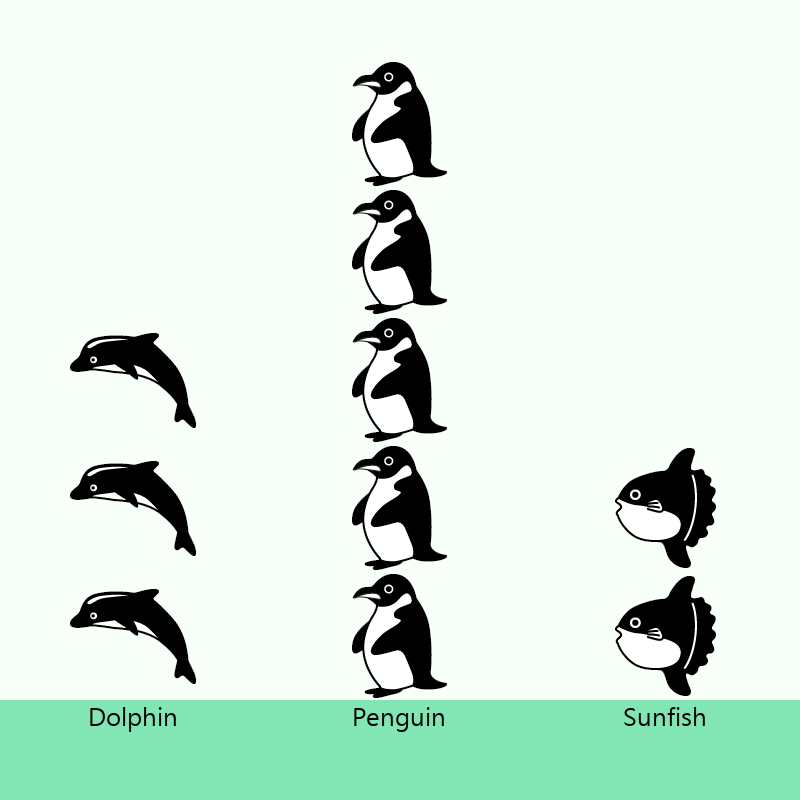

In [10]:
# 預設圖示的大小一致
# 圖示的大小
icon_size = (128, 128)

# 整張圖表的大小（圖表的高度會自動擴張）
canvas_size = (800, 800)

# 圖表區塊的背景色
graph_back_color = (248, 255, 248)

# 標籤區塊的背景色
label_back_color = (130, 230, 180)

# 定義資料
data = [
    {
        "label": "Dolphin",  # 標籤
        "image": "dolphin.png",  # 用於堆疊的圖片
        "value": 3  # 堆疊個數
    },
    {
        "label": "Penguin",
        "image": "penguin.png",
        "value": 5
    },
    {
        "label": "Sunfish",
        "image": "sunfish.png",
        "value": 2
    },
]


ig = IconGraph(data, icon_size, canvas_size, graph_back_color, label_back_color)
ig.get_image()